# Cough Audio Classification with Deep Learning
# Wiktor Raczek, Mateusz Woźniak - IEM

**Dataset**: [CoughVid WAV on Kaggle](https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav)

This repository contains a deep learning pipeline for classifying cough audio recordings using a fully connected neural network. The notebook processes audio data, extracts relevant features, optimizes model performance using Optuna, and evaluates the results using standard classification metrics.

---

## Technologies Used
- Programming Language: Python 3
- Framework: PyTorch
- Audio Processing: librosa
- Data Handling: pandas, numpy
- Visualization: matplotlib
- Hyperparameter Optimization: Optuna
- Dataset Access: kagglehub
- Progress Tracking: tqdm

---

## Pipeline Overview

### 1. Data Loading

The dataset is programmatically downloaded using kagglehub. The pipeline processes 10,553 waveforms and extracts features from cough segments. The final dataset contains 6,555 records after processing.

### 2. Audio Preprocessing

Raw audio files are loaded using librosa. Each audio clip is:
- Segmented using a custom cough detection function based on energy thresholds
- Only segments longer than 8000 samples are processed
- Padded or truncated to a fixed length (AUDIO_LENGTH)

### 3. Feature Engineering

Multiple audio features are extracted:
- MFCC features (40 coefficients)
- Chroma features (12 features representing musical notes)
- Mel spectrogram features (128 mel bands)
- Spectral contrast features

### 4. Model Architecture

The classification model is a feedforward neural network with:
- Input layer matching the feature vector size
- Hidden layers with sizes [256, 128, 64, 32]
- Dropout rate of 0.3 for regularization
- Output layer for binary classification

### 5. Training

The model is trained with:
- Binary cross-entropy loss
- Adam optimizer
- 50 epochs
- Training and validation metrics tracked per epoch

### 6. Evaluation

The model is evaluated on individual segments, comparing predicted vs actual labels for each cough segment.

### 7. Hyperparameter Optimization

Optuna is used to optimize model hyperparameters through 100 trials, focusing on:
- Network architecture
- Learning rate
- Batch size
- Other training parameters


In [356]:
# import necessary libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import kagglehub
import optuna
import optuna.visualization
import plotly.io as pio
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [357]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [358]:
# Constants
ROOT = kagglehub.dataset_download("nasrulhakim86/coughvid-wav") + '/public_dataset/'
AUDIO_LENGTH = 22050

def load_dataset(take=None):
    print(f'Using dataset from {ROOT}')
    json_files = []
    for file in os.listdir(ROOT):
        if file.endswith('.json'):
            with open(os.path.join(ROOT, file)) as f:
                json_data = json.load(f)
                json_data['uuid'] = file.split('.')[0]
                json_files.append(json_data)

    df = pd.DataFrame(json_files)
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    if take is not None:
        df = df.head(take)

    df['cough_detected'] = df['cough_detected'].astype(float)

    # drop null status
    df = df[df.status.notna()]
    # drop cough_detected < 0.8
    df = df[df.cough_detected >= 0.8]
    return df

In [359]:
def segment_cough(x, fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier=0.1, th_h_multiplier=2):
    # Initialize cough mask and calculate RMS-based thresholds
    cough_mask = np.array([False] * len(x))
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms  # Lower threshold for cough detection
    seg_th_h = th_h_multiplier * rms  # Higher threshold for cough detection

    # Initialize variables for cough detection
    cough_segments = []
    padding = round(fs * cough_padding)  # Convert padding to samples
    min_cough_samples = round(fs * min_cough_len)  # Convert minimum length to samples
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01 * fs)  # Tolerance for noise
    below_th_counter = 0

    # Process audio signal to detect coughs
    for i, sample in enumerate(x ** 2):
        if cough_in_progress:
            # Check if signal drops below lower threshold
            if sample < seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    # End of cough detected
                    cough_end = i + padding if (i + padding < len(x)) else len(x) - 1
                    cough_in_progress = False
                    # Add segment if it meets minimum length requirement
                    if cough_end + 1 - cough_start - 2 * padding > min_cough_samples:
                        cough_segments.append(x[cough_start:cough_end + 1])
                        cough_mask[cough_start:cough_end + 1] = True
            # Handle end of signal
            elif i == (len(x) - 1):
                cough_end = i
                cough_in_progress = False
                if cough_end + 1 - cough_start - 2 * padding > min_cough_samples:
                    cough_segments.append(x[cough_start:cough_end + 1])
            else:
                below_th_counter = 0
        else:
            # Check for start of new cough
            if sample > seg_th_h:
                cough_start = i - padding if (i - padding >= 0) else 0
                cough_in_progress = True

    return cough_segments, cough_mask

In [360]:
def extract_features(audio_data, sample_rate):
    
    features = []
    
    # Compute Short-time Fourier transform
    stft = np.abs(librosa.stft(audio_data))

    # Extract MFCC features (40 coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
    features.extend(mfcc)

    # Extract chroma features (12 features representing musical notes)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features.extend(chroma)

    # Extract mel spectrogram features (128 mel bands)
    mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T, axis=0)
    features.extend(mel)

    # Calculate minimum frequency for spectral contrast
    min_val = 0.5 * sample_rate * 2 ** (-6)
    # Extract spectral contrast features
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, fmin=min_val).T, axis=0)
    features.extend(contrast)

    return np.array(features)

In [361]:
def load_features(df):
    # Initialize empty lists to store features and filenames
    features, filenames = [], []
    
    # Iterate through each row in the dataframe
    for idx in tqdm(range(len(df))):
        # Get filename from uuid column
        filename = df.uuid.iloc[idx]
        path = os.path.join(ROOT + filename + '.wav')

        # Load audio file and get sample rate
        audio, sample_rate = librosa.load(path, mono=True)
        # Segment cough sounds from audio
        cough_segments, cough_mask = segment_cough(audio, sample_rate, min_cough_len=0.1, cough_padding=0.1,
                                                   th_l_multiplier=0.1, th_h_multiplier=2)

        # Process each cough segment if any were found
        if len(cough_segments) > 0:
            i = 0
            for audio in cough_segments:
                i += 1
                # Only process segments longer than 8000 samples
                if len(audio) > 8000:
                    # Pad or truncate audio to fixed length
                    if len(audio) < AUDIO_LENGTH:
                        audio_pad = librosa.util.pad_center(audio, size=AUDIO_LENGTH)
                    else:
                        audio_pad = audio[:AUDIO_LENGTH]

                # Extract features from processed audio segment
                feature = extract_features(audio_pad, sample_rate)
                features.append(feature)
                filenames.append(filename)

    # Return arrays of filenames and their corresponding features
    return np.array(filenames), np.array(features)

In [362]:
def aggregate_features(processed_df, uuid, X):
    # Split features into different types based on their indices
    x_mfcc = X[:, 0:40]  # MFCC features (first 40 columns)
    x_chroma = X[:, 40:52]  # Chroma features (next 12 columns)
    x_mel = X[:, 52:180]  # Mel spectrogram features (next 128 columns)
    x_contrast = X[:, 180:]  # Spectral contrast features (remaining columns)

    # Create DataFrame for UUIDs
    uuid_df = pd.DataFrame({'uuid': uuid})
    
    # Create and name columns for MFCC features
    mfcc_df = pd.DataFrame(x_mfcc)
    mfcc_df.columns = ["mfcc" + str(i) for i in range(1, x_mfcc.shape[1] + 1)]

    # Create and name columns for Mel spectrogram features
    mel_df = pd.DataFrame(x_mel)
    mel_df.columns = ["mel" + str(i) for i in range(1, x_mel.shape[1] + 1)]

    # Create and name columns for Chroma features
    chroma_df = pd.DataFrame(x_chroma)
    chroma_df.columns = ["chr" + str(i) for i in range(1, x_chroma.shape[1] + 1)]

    # Create and name columns for Spectral contrast features
    contrast_df = pd.DataFrame(x_contrast)
    contrast_df.columns = ["con" + str(i) for i in range(1, x_contrast.shape[1] + 1)]

    # Combine all feature DataFrames
    all_df = pd.concat([uuid_df, mfcc_df, mel_df, chroma_df, contrast_df], axis=1)
    
    # Get status labels from processed dataframe
    label_df = processed_df[['uuid', 'status']].reset_index(drop=True)

    # Merge features with labels
    dataset = pd.merge(all_df, label_df, on='uuid')
    
    # Remove unknown status entries
    dataset = dataset[dataset.status != 'unknown']
    
    # Balance the dataset by sampling equal number of samples from each status
    dataset = dataset.groupby('status').sample(n=2185)

    return dataset

In [363]:
def plot_training_results(train_losses, train_accs, val_losses, val_accs, early_stop_epoch=None, early_stop_reason=None):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create epochs array starting from 1 instead of 0
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Plot loss function with epochs starting from 1
    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    # Add early stopping vertical line if available
    if early_stop_epoch is not None:
        # Add 1 to early_stop_epoch to account for 1-indexed plotting
        early_stop_epoch_adjusted = early_stop_epoch + 1
        label = 'Early Stop (Overfitting)' if early_stop_reason == 'overfitting' else 'Early Stop (No Improvement)'
        ax1.axvline(x=early_stop_epoch_adjusted, color='r', linestyle='--', label=label)
        
        # Add loss gap visualization to highlight overfitting
        if early_stop_reason == 'overfitting':
            # Plot the difference between train and validation loss
            for i in range(len(train_losses)):
                if i > early_stop_epoch - 3:  # Highlight gaps near and after early stopping
                    ax1.plot([i+1, i+1], [train_losses[i], val_losses[i]], 'r-', alpha=0.3)
    
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy with epochs starting from 1
    ax2.plot(epochs, train_accs, label='Train Accuracy')
    ax2.plot(epochs, val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    
    # Add early stopping vertical line if available
    if early_stop_epoch is not None:
        # Add 1 to early_stop_epoch to account for 1-indexed plotting
        early_stop_epoch_adjusted = early_stop_epoch + 1
        label = 'Early Stop (Overfitting)' if early_stop_reason == 'overfitting' else 'Early Stop (No Improvement)'
        ax2.axvline(x=early_stop_epoch_adjusted, color='r', linestyle='--', label=label)
    
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [364]:
def plot_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix using true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a new figure with specified size
    plt.figure(figsize=(8, 6))
    
    # Create heatmap visualization of confusion matrix
    # annot=True shows numbers in cells, fmt='d' formats as integers, cmap='Blues' sets color scheme
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Set plot title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Display the plot
    plt.show()

In [365]:
def plot_roc_curve(y_true, y_pred_prob):
    # Calculate ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with specified size
    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve with AUC score in label
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    
    # Add legend and grid
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [366]:
def save_classification_report_png(y_true, y_pred, filename="classification_report.png"):
    # Wygeneruj raport tekstowy
    report = classification_report(y_true, y_pred)
    
    # Utwórz wykres z tekstem raportu
    plt.figure(figsize=(10, 5))
    plt.text(0, 1, report, fontsize=12, family='monospace', verticalalignment='top')
    plt.axis('off')
    plt.tight_layout()
    
    # Zapisz jako PNG
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Classification report saved as '{filename}'")

In [367]:
class DenseNet(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout_rate):
        super(DenseNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Creating hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_dim, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_size
            
        # Output layer
        layers.extend([
            nn.Linear(prev_dim, 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [368]:
def objective(trial, X, y):
    # Number of layers as a hyperparameter
    n_layers = trial.suggest_int('n_layers', 1, 6)
    
    # Hidden layer sizes
    hidden_sizes = []
    for i in range(n_layers):
        size = trial.suggest_categorical(f'hidden_size_{i}', [8, 12, 16, 24, 32, 64, 128])
        hidden_sizes.append(size)
    
    # Single dropout parameter for all layers
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Remaining hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    epochs = trial.suggest_int('epochs', 1, 50)
    # Add early stopping threshold as a hyperparameter
    overfitting_threshold = 0.03  # Same as used in the train function

    # Data preparation
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    x_train_tensor = torch.FloatTensor(x_train)
    x_test_tensor = torch.FloatTensor(x_test)
    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)
    
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Create model with new hyperparameters
    model = DenseNet(
        input_dim=x_train.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rate=dropout_rate
    )
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    best_loss_diff = float('inf')  # Track the best loss difference
    patience = 5
    patience_counter = 0
    
    # Keep track of training and validation losses for early stopping
    train_losses = []
    val_losses = []
    early_stopped = False
    early_stop_reason = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0
        
        for inputs, labels in train_loader:
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_total += inputs.size(0)
        
        train_epoch_loss = train_loss / train_total
        train_losses.append(train_epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_total += inputs.size(0)
        
        val_epoch_loss = val_loss / val_total
        val_losses.append(val_epoch_loss)
        
        # Calculate loss gap to detect overfitting
        loss_gap = train_epoch_loss - val_epoch_loss
        
        # Calculate absolute difference between train and validation loss for the objective
        loss_diff = abs(train_epoch_loss - val_epoch_loss)
        
        # Combined objective: validation loss + loss difference
        # This encourages models with both low validation loss and small train-val difference
        combined_objective = val_epoch_loss + loss_diff
        
        # Early stopping checks
        # 1. Check for improvement in combined objective
        if combined_objective < best_val_loss:
            best_val_loss = combined_objective
            best_loss_diff = loss_diff
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stopped = True
                early_stop_reason = 'no_improvement'
                break
        
        # 2. Check for early stopping due to overfitting
        if epoch > 5:  # Start checking after a few epochs
            # If training loss decreases but validation loss increases
            if (len(train_losses) > 1 and 
                train_epoch_loss < train_losses[-2] and 
                val_epoch_loss > val_losses[-2]):
                
                # If the gap between train and val loss is too large (negative means train is lower than val)
                if loss_gap < -overfitting_threshold:
                    early_stopped = True
                    early_stop_reason = 'overfitting'
                    break
    
    # Log additional information
    trial.set_user_attr("train_val_loss_diff", best_loss_diff)
    trial.set_user_attr("early_stopped", early_stopped)
    trial.set_user_attr("early_stop_reason", early_stop_reason)
    trial.set_user_attr("epochs_trained", epoch + 1)
    
    return best_val_loss  # Return the combined objective

In [369]:
def optimize_hyperparameters(data, n_trials=100):
    # Extract features (X) and target variable (y) from the dataset
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]
    # Convert target labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)
    
    # Create an Optuna study for hyperparameter optimization
    study = optuna.create_study(direction='minimize', study_name="coughvid_analysis")
    # Run optimization trials using the objective function
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    # Get trial values and other metadata
    trial_values = [t.value for t in study.trials if t.value is not None]
    loss_diffs = [t.user_attrs.get("train_val_loss_diff", float('nan')) for t in study.trials]
    epochs_trained = [t.user_attrs.get("epochs_trained", float('nan')) for t in study.trials]
    
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot objective values for each trial
    ax1.plot(trial_values, 'b-', label='Combined Objective')
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel('Objective Value')
    ax1.set_title('Combined Objective (Val Loss + Loss Diff) vs Trial Number')
    ax1.legend()
    ax1.grid(True)
    
    # Plot train-val loss differences for each trial
    ax2.plot(loss_diffs, 'r-', label='Train-Val Loss Difference')
    ax2.set_xlabel('Trial Number')
    ax2.set_ylabel('Loss Difference')
    ax2.set_title('Train-Val Loss Difference vs Trial Number')
    ax2.legend()
    ax2.grid(True)
    
    # Plot epochs trained for each trial
    ax3.plot(epochs_trained, 'g-', label='Epochs Trained')
    ax3.set_xlabel('Trial Number')
    ax3.set_ylabel('Epochs')
    ax3.set_title('Epochs Trained Before Early Stopping')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print results of the best trial
    print("Best trial:")
    trial = study.best_trial
    
    print(f"  Combined Objective Value: {trial.value:.4f}")
    print(f"  Train-Val Loss Difference: {trial.user_attrs.get('train_val_loss_diff', 'Not available'):.4f}")
    print(f"  Epochs Trained: {trial.user_attrs.get('epochs_trained', 'Not available')}")
    
    # Print early stopping information if available
    if trial.user_attrs.get('early_stopped', False):
        reason = trial.user_attrs.get('early_stop_reason', 'unknown')
        print(f"  Early Stopped: Yes (Reason: {reason})")
    else:
        print("  Early Stopped: No")
    
    print("  Params: ")
    # Print all hyperparameters from the best trial
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Count how many trials were early stopped due to overfitting
    overfitting_count = sum(1 for t in study.trials if t.user_attrs.get('early_stop_reason') == 'overfitting')
    no_improvement_count = sum(1 for t in study.trials if t.user_attrs.get('early_stop_reason') == 'no_improvement')
    completed_count = sum(1 for t in study.trials if not t.user_attrs.get('early_stopped', False))
    
    print(f"\nEarly stopping statistics (total {len(study.trials)} trials):")
    print(f"  Stopped due to overfitting: {overfitting_count} trials")
    print(f"  Stopped due to no improvement: {no_improvement_count} trials")
    print(f"  Completed full training: {completed_count} trials")
    
    # Return the best hyperparameters found
    return trial.params

In [370]:
def train(data, hyperparams=None, patience=5, overfitting_threshold=0.15):
    # Balance the dataset by sampling equal number of samples from each class
    data.groupby('status').sample(n=2185, replace=True)

    # Extract features and target variable
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]
    # Convert target labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Convert data to PyTorch tensors
    x_train_tensor = torch.FloatTensor(x_train)
    x_test_tensor = torch.FloatTensor(x_test)
    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)

    # Create PyTorch datasets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    # Set up data loaders
    batch_size = hyperparams['batch_size'] if hyperparams else 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    input_dim = x_train.shape[1]
    
    # Initialize model with hyperparameters if provided, otherwise use default values
    if hyperparams:
        hidden_sizes = []
        for i in range(hyperparams['n_layers']):
            hidden_sizes.append(hyperparams[f'hidden_size_{i}'])
        
        model = DenseNet(
            input_dim=input_dim,
            hidden_sizes=hidden_sizes,
            dropout_rate=hyperparams['dropout_rate']
        )
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        epochs = hyperparams['epochs']  # Use epochs from hyperparameters
    else:
        model = DenseNet(
            input_dim=input_dim,
            hidden_sizes=[],
            dropout_rate=0.5
        )
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        epochs = 20

    criterion = nn.BCELoss()

    # Initialize lists to store training metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    counter = 0
    early_stop_epoch = None
    early_stop_reason = None
    best_model = None

    print('Training model...')
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        # Calculate loss gap to detect overfitting
        loss_gap = epoch_loss - val_epoch_loss
        
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, '
              f'Gap: {loss_gap:.4f}')
              
        # Early stopping check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            counter = 0
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'early_stop_model.pth')
        else:
            counter += 1
        
        # Check for early stopping due to overfitting
        if epoch > 5:  # Start checking after a few epochs
            # If training loss decreases but validation loss increases
            if (epoch_loss < train_losses[-2] and 
                val_epoch_loss > val_losses[-2]):
                
                # Or if the gap between train and val loss is too large (negative means train is lower than val)
                if loss_gap < -overfitting_threshold:
                    if early_stop_epoch is None:
                        early_stop_epoch = epoch
                        early_stop_reason = 'overfitting'
                        print(f'Early stopping at epoch {epoch + 1} due to overfitting: '
                              f'Train loss ({epoch_loss:.4f}) much lower than validation loss ({val_epoch_loss:.4f})')
            
        # Check for early stopping due to no improvement
        if counter >= patience and early_stop_epoch is None:
            early_stop_epoch = epoch + 1 - patience
            early_stop_reason = 'no_improvement'
            print(f'Early stopping at epoch {epoch + 1} due to no improvement for {patience} epochs')

    # Plot training results with early stopping point and reason
    plot_training_results(train_losses, train_accs, val_losses, val_accs, early_stop_epoch, early_stop_reason)

    # Save the final model
    torch.save(model.state_dict(), 'model.pth')

    print('Evaluating early stopped model...')
    # Load the early stopped model for evaluation
    if best_model is not None:
        model.load_state_dict(torch.load('early_stop_model.pth'))
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    # Make predictions on test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.view(-1, 1)
            outputs = model(inputs)
            all_predictions.extend((outputs > 0.5).float().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())

    y_pred = np.array(all_predictions).flatten()
    y_true = np.array(all_labels).flatten()
    y_prob = np.array(all_probabilities).flatten()

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve
    plot_roc_curve(y_true, y_prob)

    print("\nClassification Report (Early Stopped Model):")
    print(classification_report(y_true, y_pred))
    save_classification_report_png(y_true, y_pred)
    
    # Return the training history for further analysis if needed
    return {'train_loss': train_losses, 
            'train_acc': train_accs, 
            'val_loss': val_losses, 
            'val_acc': val_accs, 
            'early_stop_epoch': early_stop_epoch,
            'early_stop_reason': early_stop_reason}

In [371]:
def evaluate_single_sample(data, uuid):
    # Filter data for specific UUID
    df = data[data['uuid'] == uuid]

    # Extract features and labels
    X = df.iloc[:, 1:-1]  # All columns except first and last
    y = df.iloc[:, -1]    # Last column contains labels

    # Convert labels to binary (1 for COVID-19, 0 for others)
    y = y.apply(lambda x: 1 if x == 'COVID-19' else 0)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert data to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y.values)

    # Create PyTorch dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Initialize model with default architecture
    model = DenseNet(
        input_dim=X.shape[1],
        hidden_sizes=[256, 128, 64, 32],
        dropout_rate=0.3
    )
    # Load early stopped model weights
    model.load_state_dict(torch.load('early_stop_model.pth'))

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataset):
            # Get model predictions
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            print('Segment', idx, 'Predicted:', predicted.item(), 'Actual:', labels.item())

In [372]:
# Check if dataset.csv already exists
import os

if os.path.exists('dataset.csv'):
    print('Loading existing dataset from dataset.csv')
    dataset = pd.read_csv('dataset.csv')
    print(f'Dataset records count: {len(dataset)}')
else:
    # Load and preprocess data from the dataset
    processed_df = load_dataset()
    print(f'Extracting spectrogram features from {len(processed_df)} waveforms')
    # Extract features and UUIDs from the processed data
    uuid, x = load_features(processed_df)
    # Combine features into a single dataset
    dataset = aggregate_features(processed_df, uuid, x)
    print(f'Dataset records count: {len(dataset)}')
    
    # Save the processed dataset to CSV for future use
    dataset.to_csv('dataset.csv', index=False)

Loading existing dataset from dataset.csv
Dataset records count: 6555


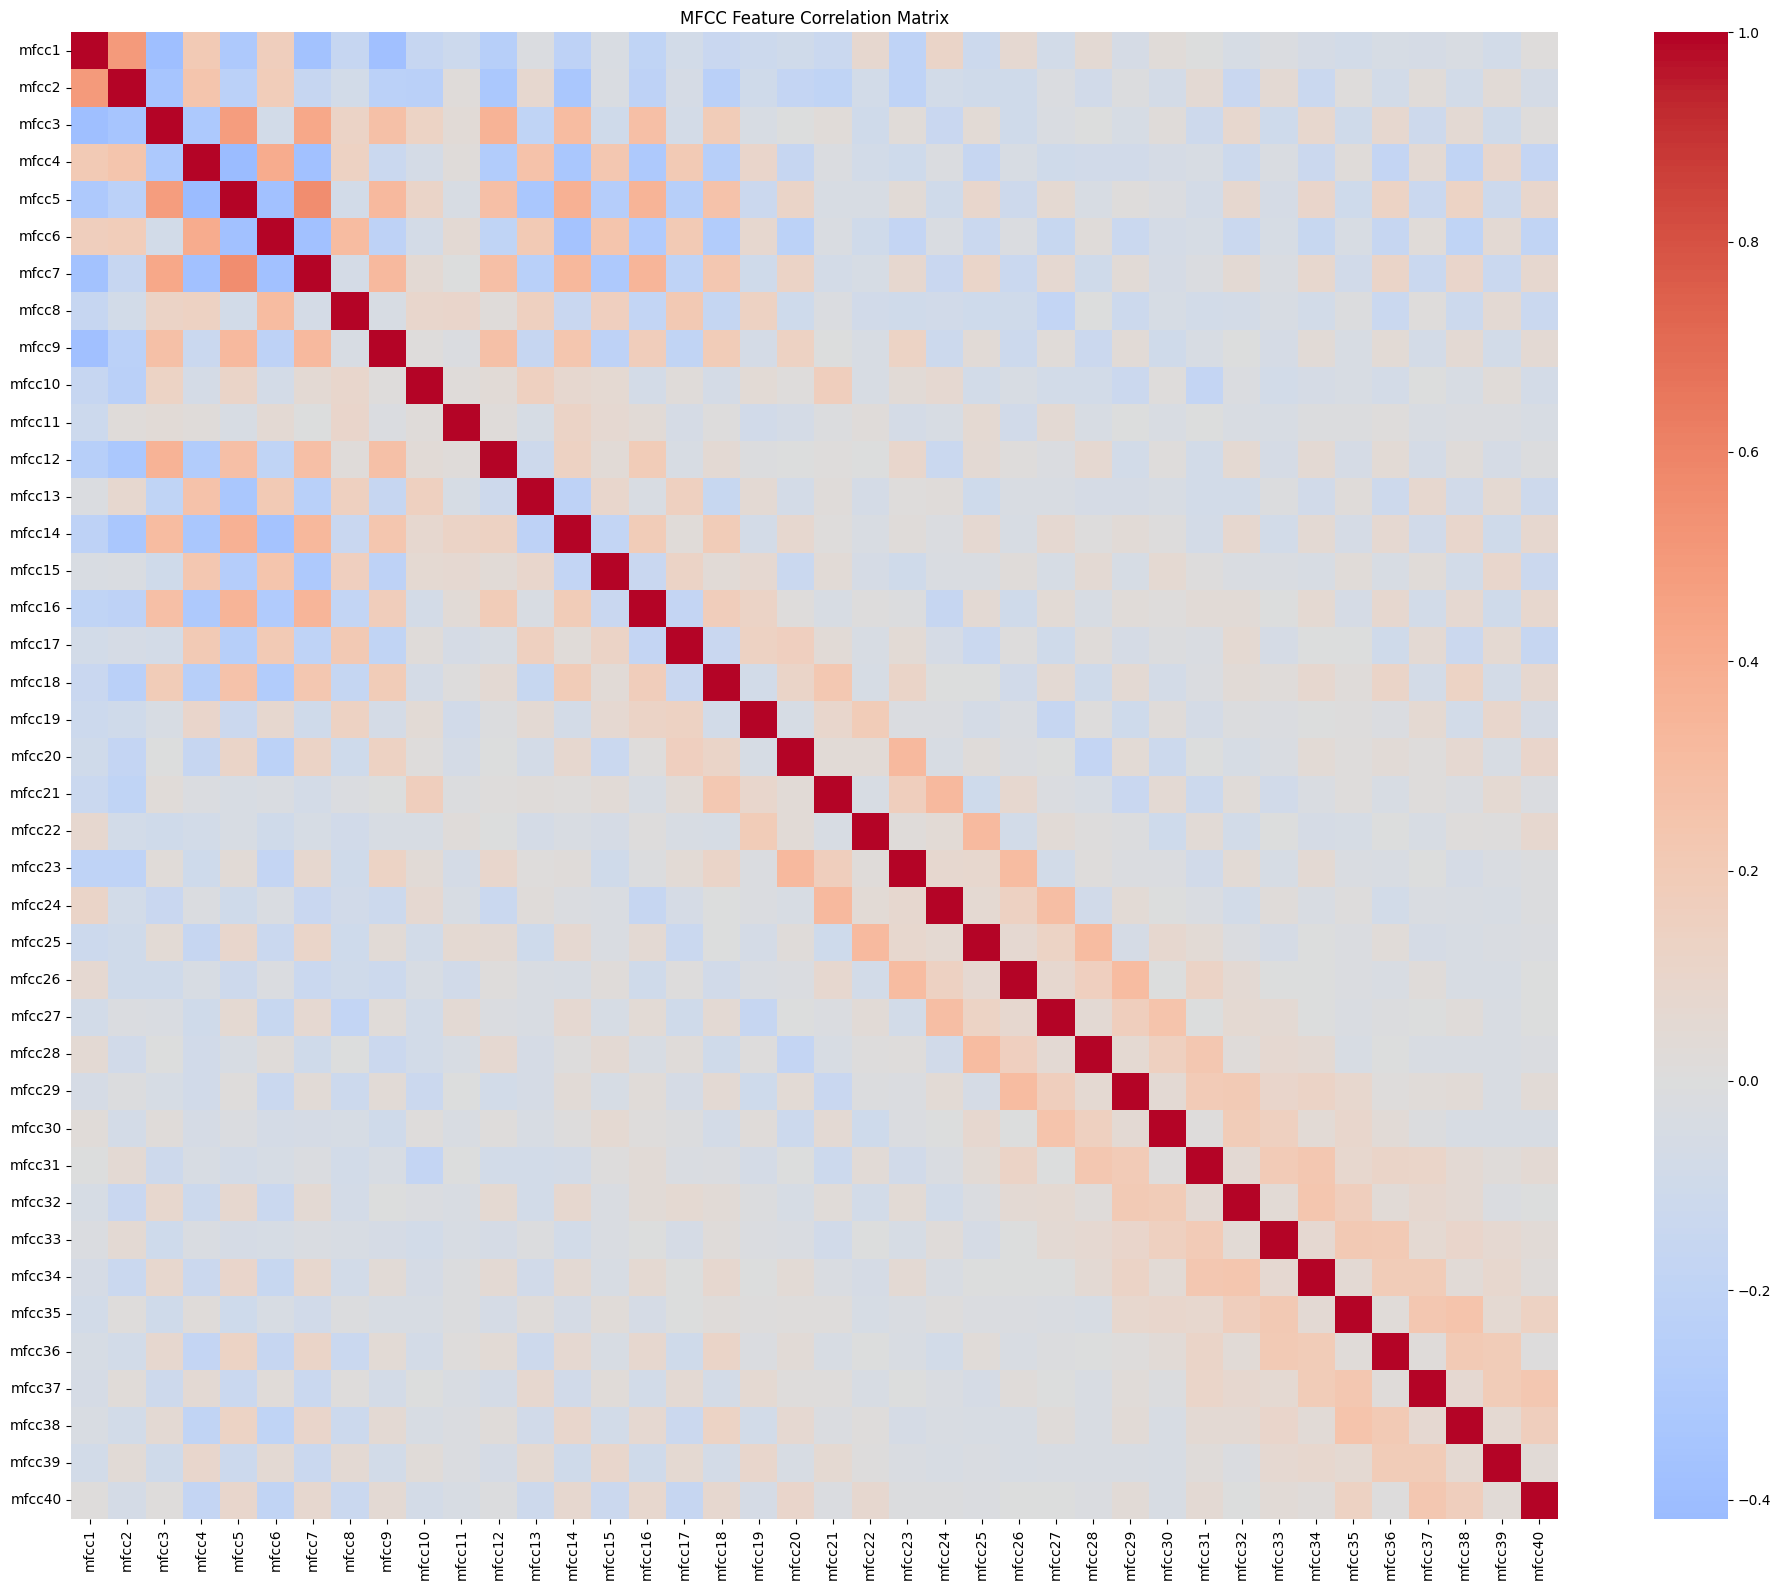

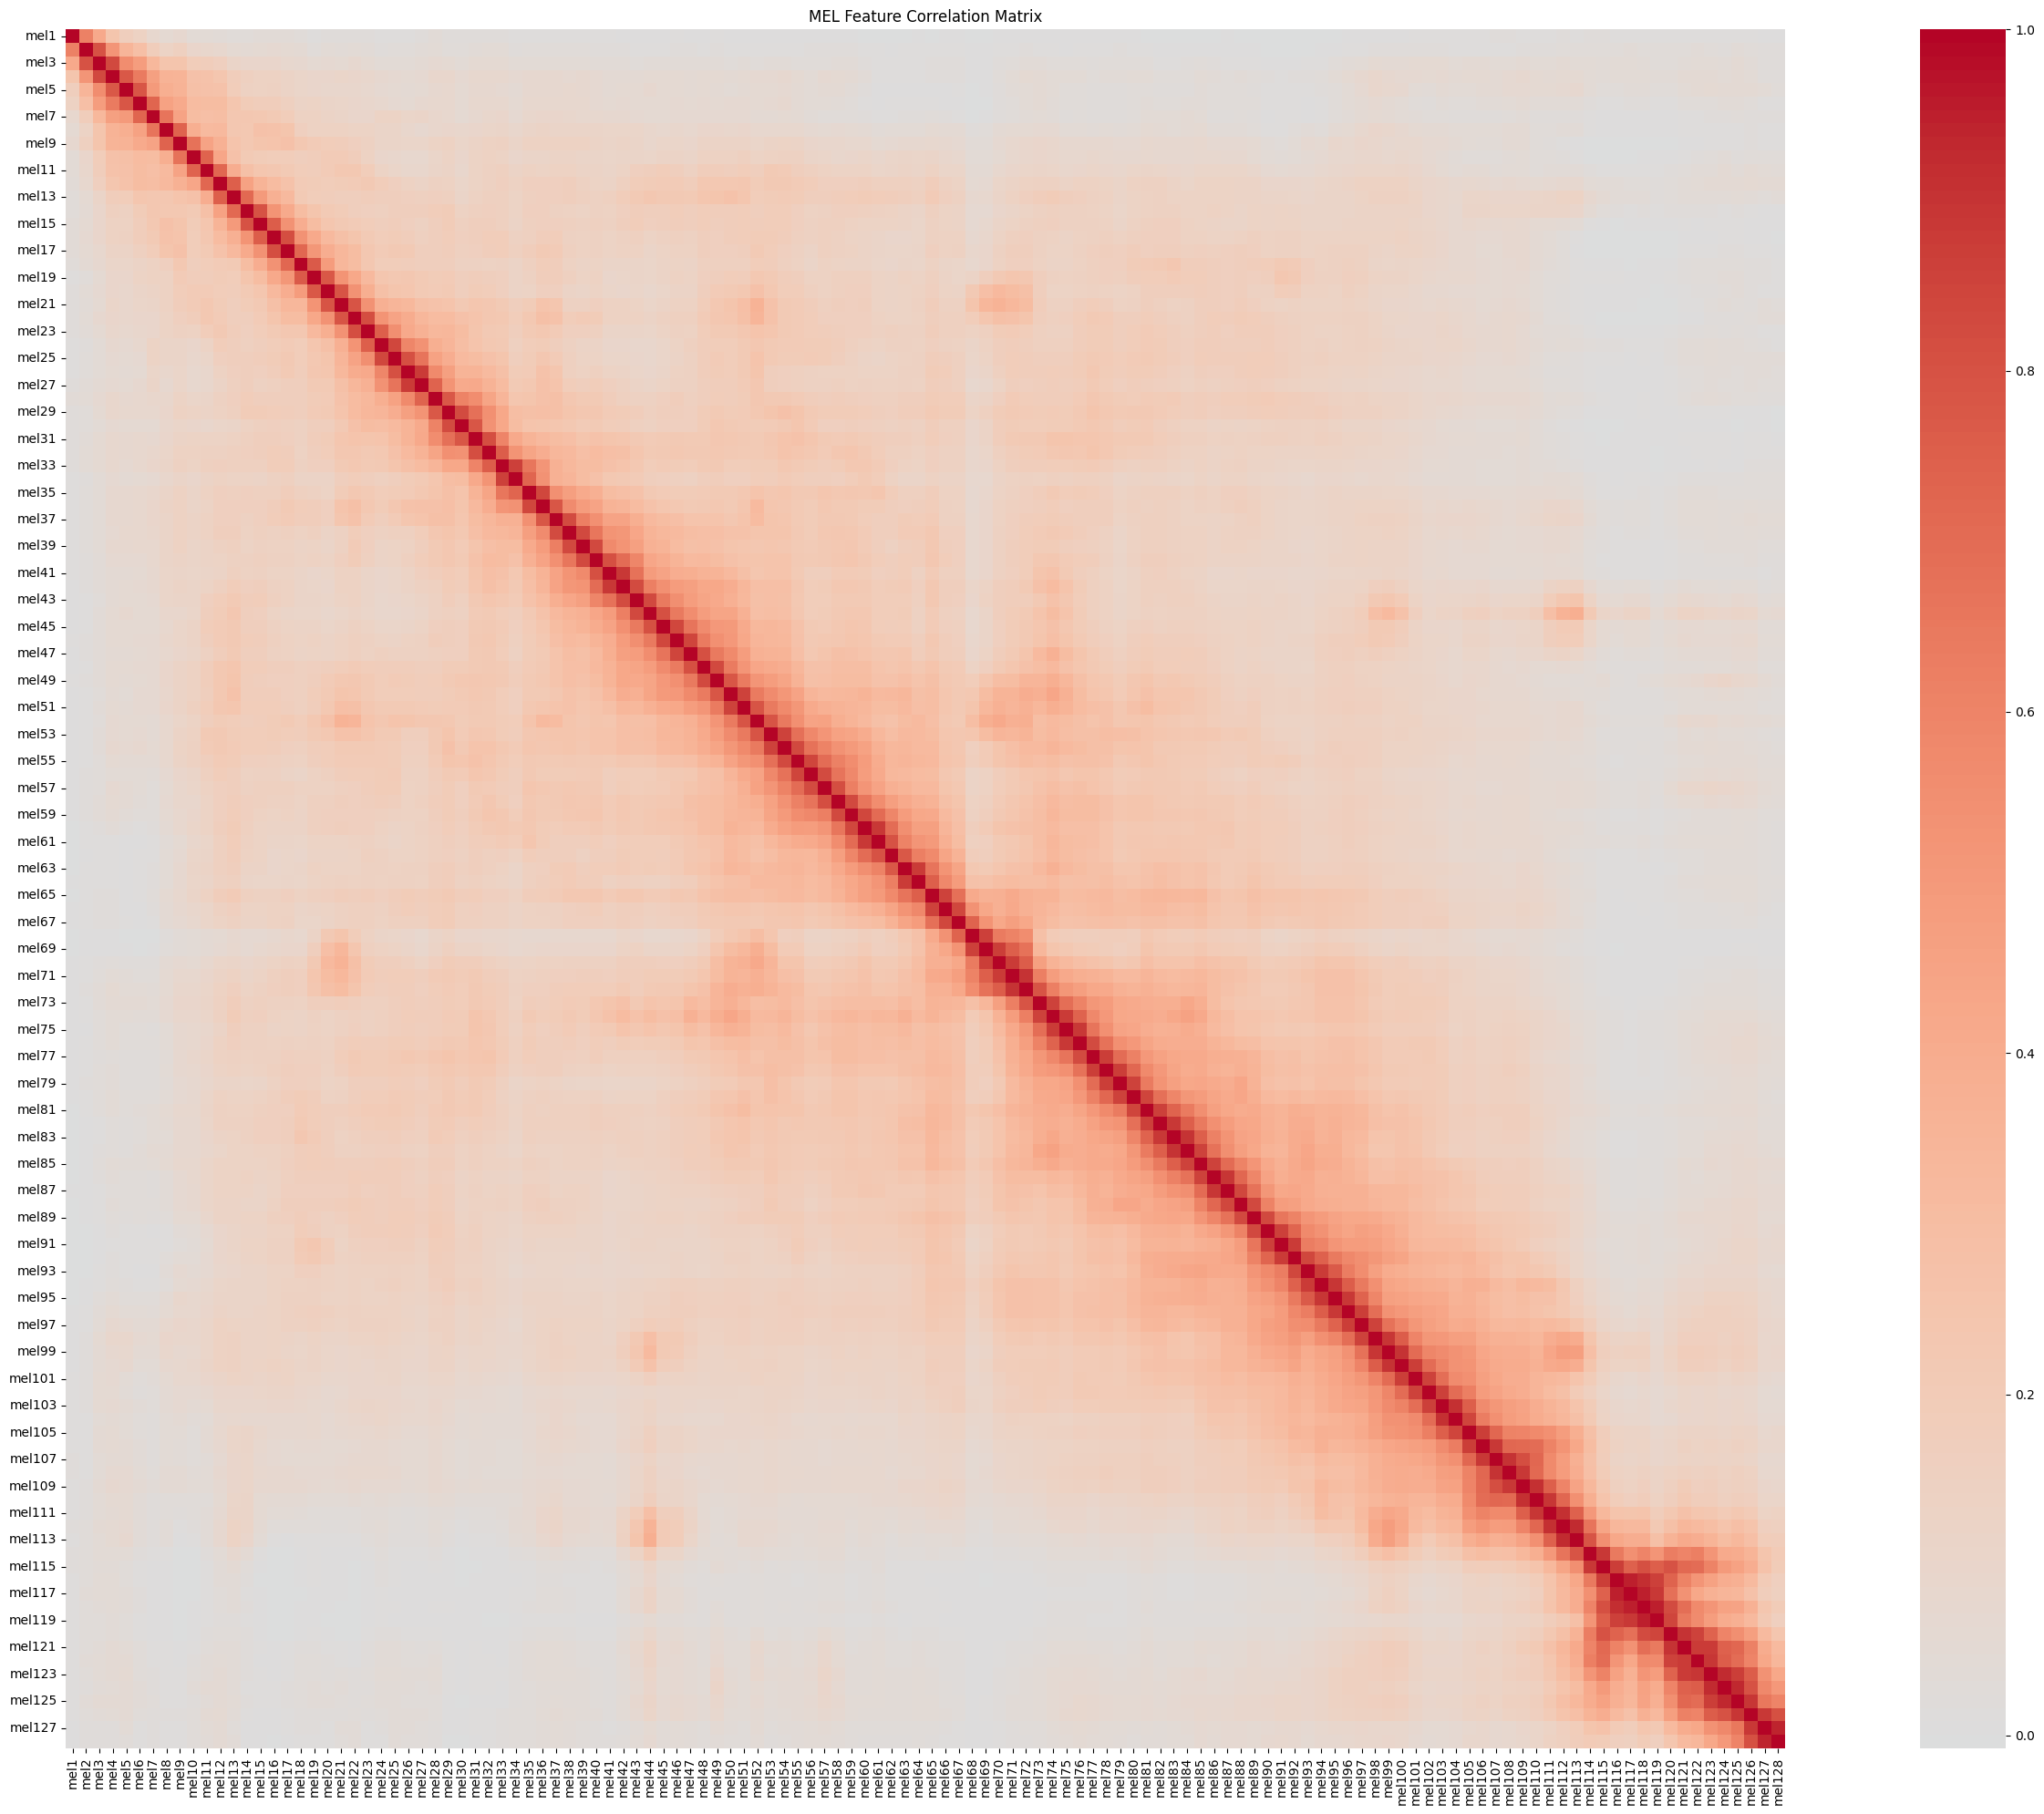

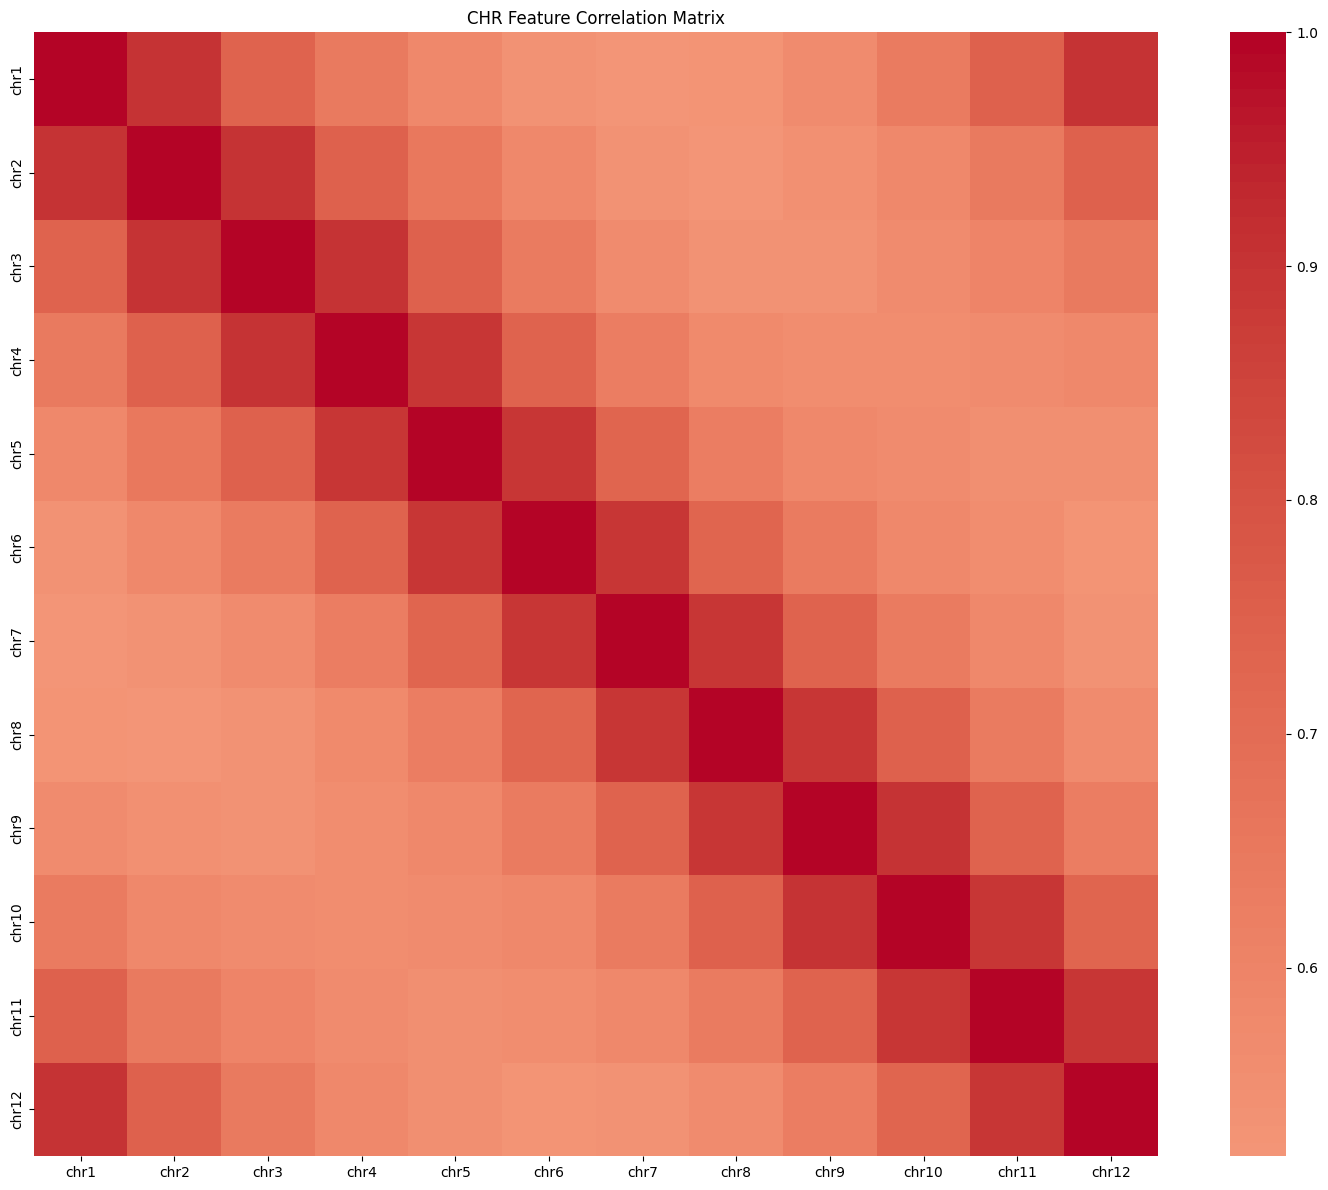

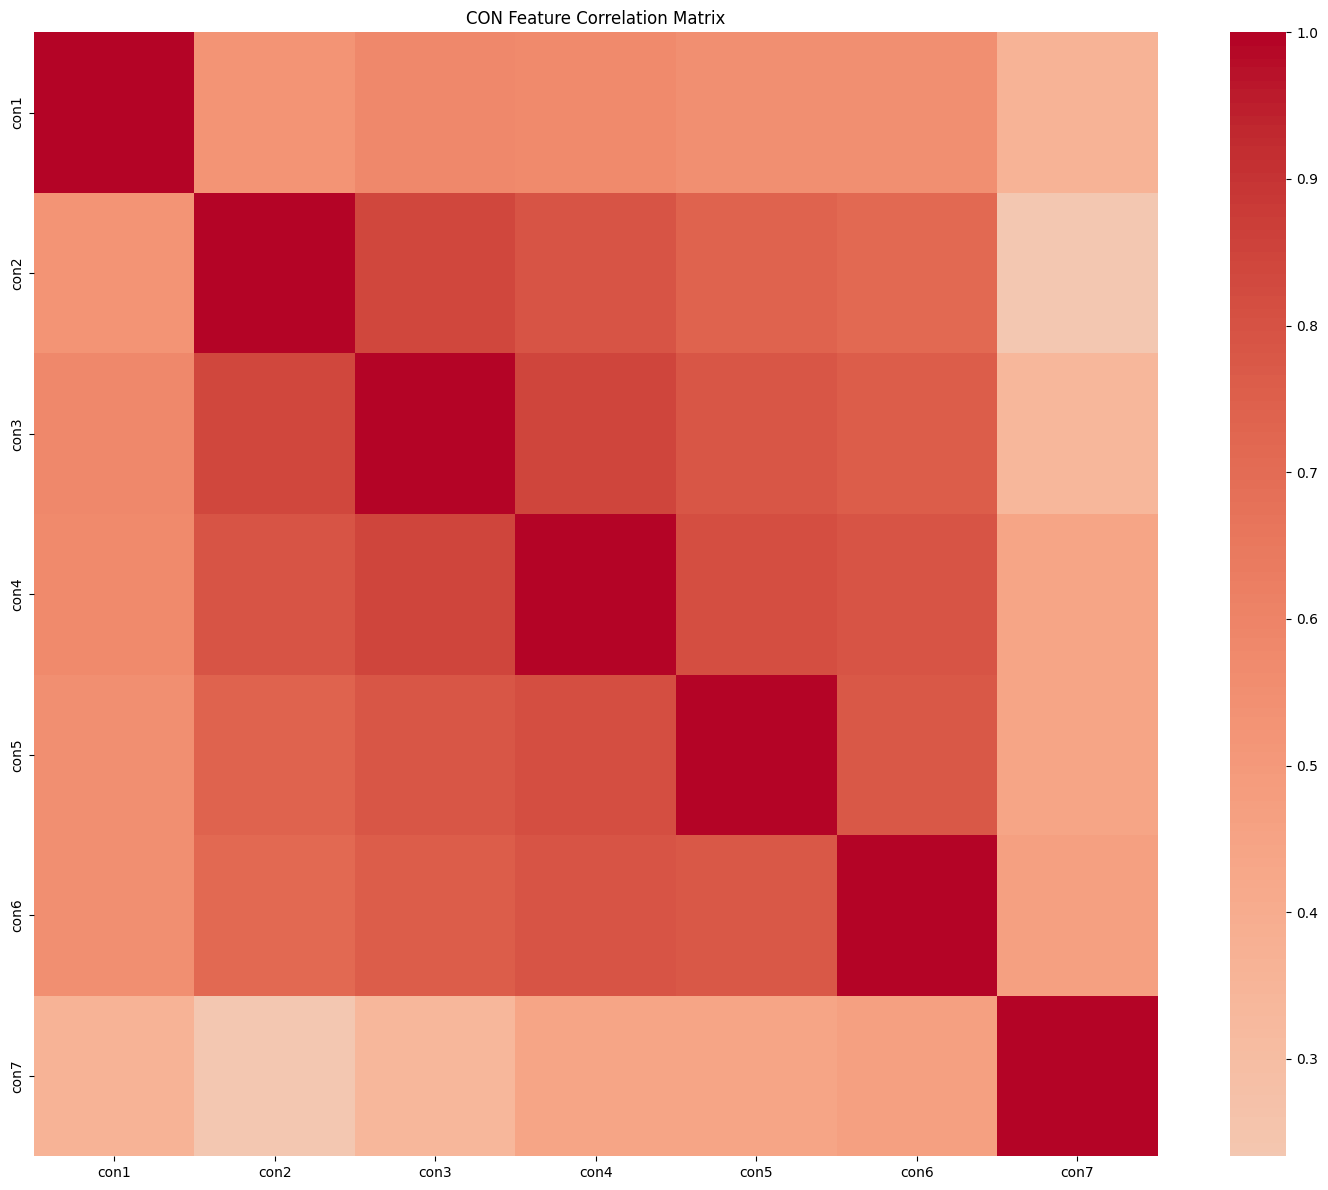


Top 10 positive correlations for MFCC:
mfcc1   mfcc1     1.0
mfcc22  mfcc22    1.0
mfcc20  mfcc20    1.0
mfcc19  mfcc19    1.0
mfcc18  mfcc18    1.0
mfcc17  mfcc17    1.0
mfcc16  mfcc16    1.0
mfcc15  mfcc15    1.0
mfcc14  mfcc14    1.0
mfcc13  mfcc13    1.0
dtype: float64

Top 10 negative correlations for MFCC:
mfcc4  mfcc5   -0.418010
mfcc5  mfcc4   -0.418010
mfcc1  mfcc3   -0.391997
mfcc3  mfcc1   -0.391997
mfcc1  mfcc9   -0.384316
mfcc9  mfcc1   -0.384316
mfcc5  mfcc6   -0.376506
mfcc6  mfcc5   -0.376506
mfcc7  mfcc6   -0.375185
mfcc6  mfcc7   -0.375185
dtype: float64

Top 10 positive correlations for MEL:
mel1   mel1     1.0
mel50  mel50    1.0
mel37  mel37    1.0
mel38  mel38    1.0
mel39  mel39    1.0
mel40  mel40    1.0
mel41  mel41    1.0
mel42  mel42    1.0
mel43  mel43    1.0
mel44  mel44    1.0
dtype: float64

Top 10 negative correlations for MEL:
mel115  mel16    -0.007452
mel16   mel115   -0.007452
mel115  mel17    -0.007237
mel17   mel115   -0.007237
mel116  mel16    -0

In [373]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# Convert status labels to numeric values
df['status'] = df['status'].map({
    'healthy': 0,
    'COVID-19': 1,
    'symptomatic': 1
})

# Exclude non-numeric columns (like UUID) before calculating correlations
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Create separate heatmaps for each feature type
feature_types = ['mfcc', 'mel', 'chr', 'con']

# Create individual figures for each feature type
for feature_type in feature_types:
    # Filter columns for current feature type
    feature_cols = [col for col in correlation_matrix.columns if feature_type in col]
    feature_corr = correlation_matrix.loc[feature_cols, feature_cols]
    
    # Create figure with appropriate size based on feature type
    if feature_type == 'mfcc':
        figsize = (20, 16)
    elif feature_type == 'mel':
        figsize = (30, 20)
    else:
        figsize = (15, 12)
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(feature_corr,
                cmap='coolwarm',
                center=0,
                annot=False,
                fmt='.2f',
                square=True)
    
    plt.title(f'{feature_type.upper()} Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Print top correlations for each feature type
for feature_type in feature_types:
    print(f"\nTop 10 positive correlations for {feature_type.upper()}:")
    feature_cols = [col for col in correlation_matrix.columns if feature_type in col]
    feature_corr = correlation_matrix.loc[feature_cols, feature_cols]
    correlations = feature_corr.unstack()
    positive_correlations = correlations[correlations > 0].sort_values(ascending=False)
    print(positive_correlations.head(10))

    print(f"\nTop 10 negative correlations for {feature_type.upper()}:")
    negative_correlations = correlations[correlations < 0].sort_values()
    print(negative_correlations.head(10))


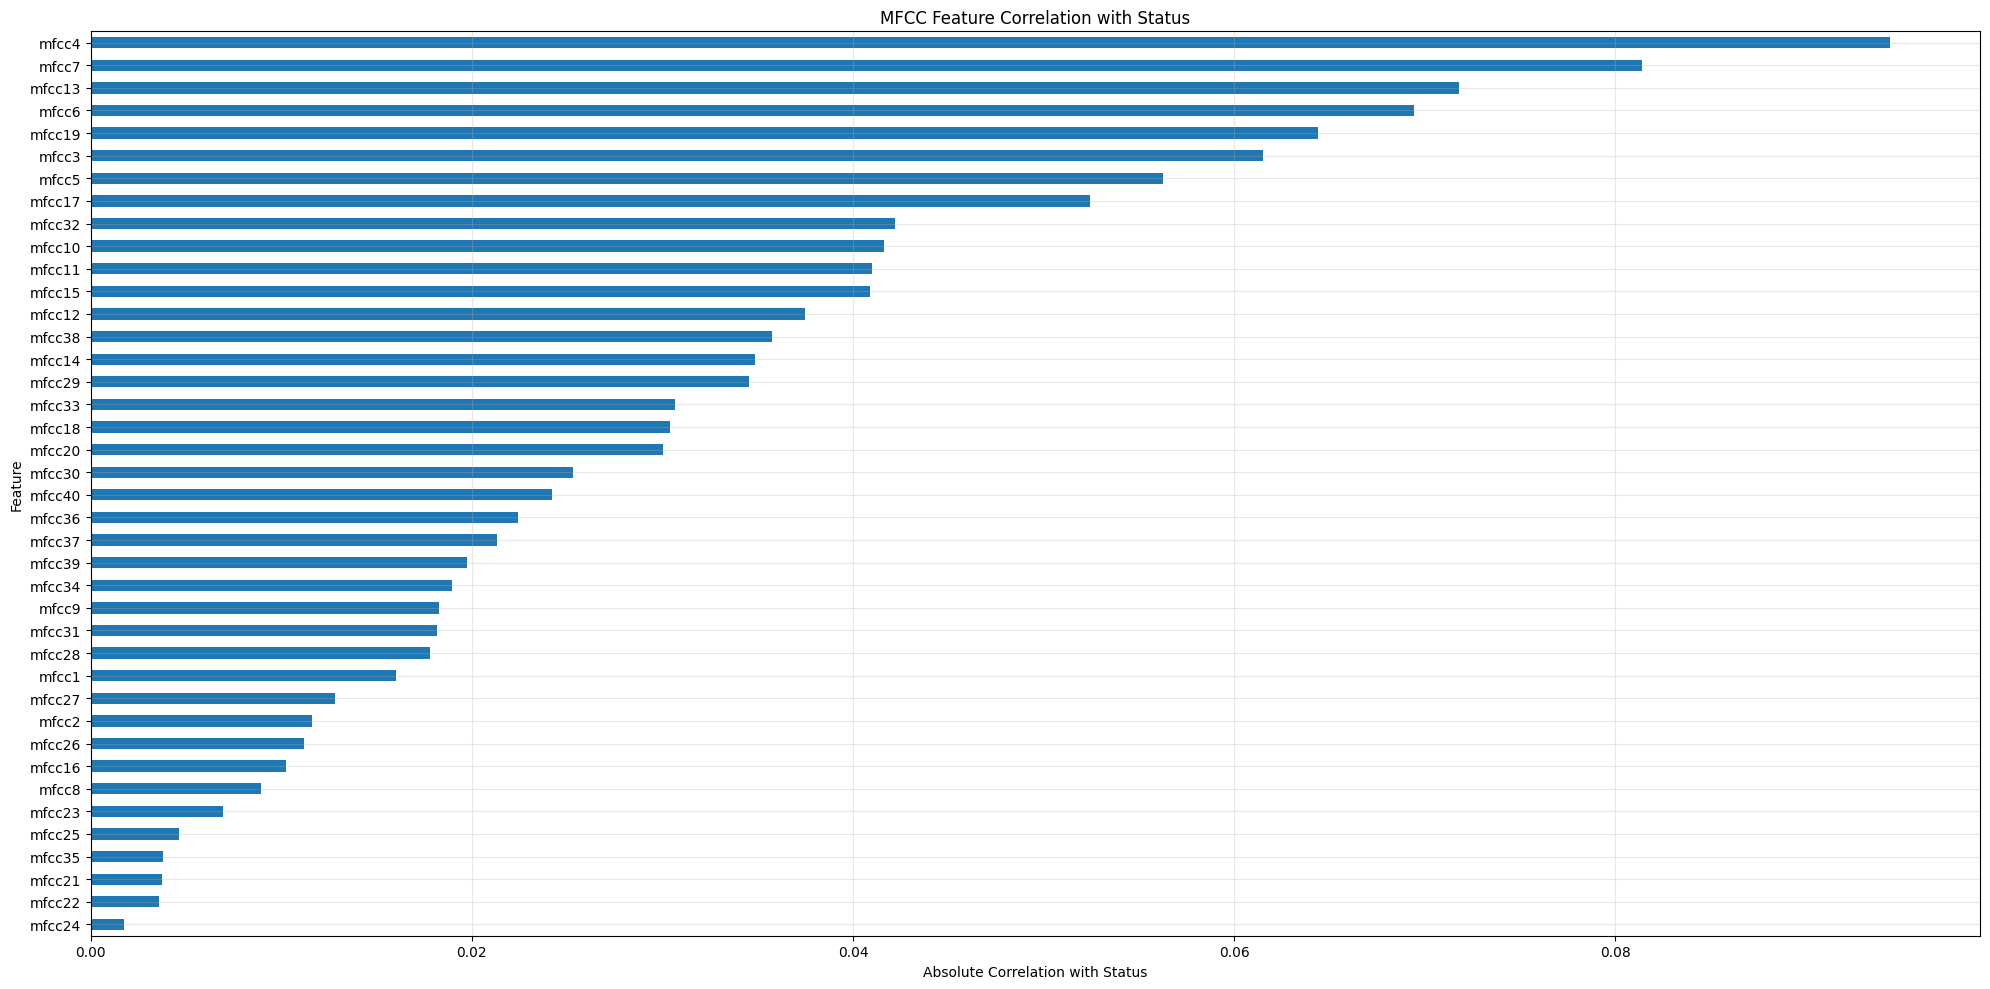

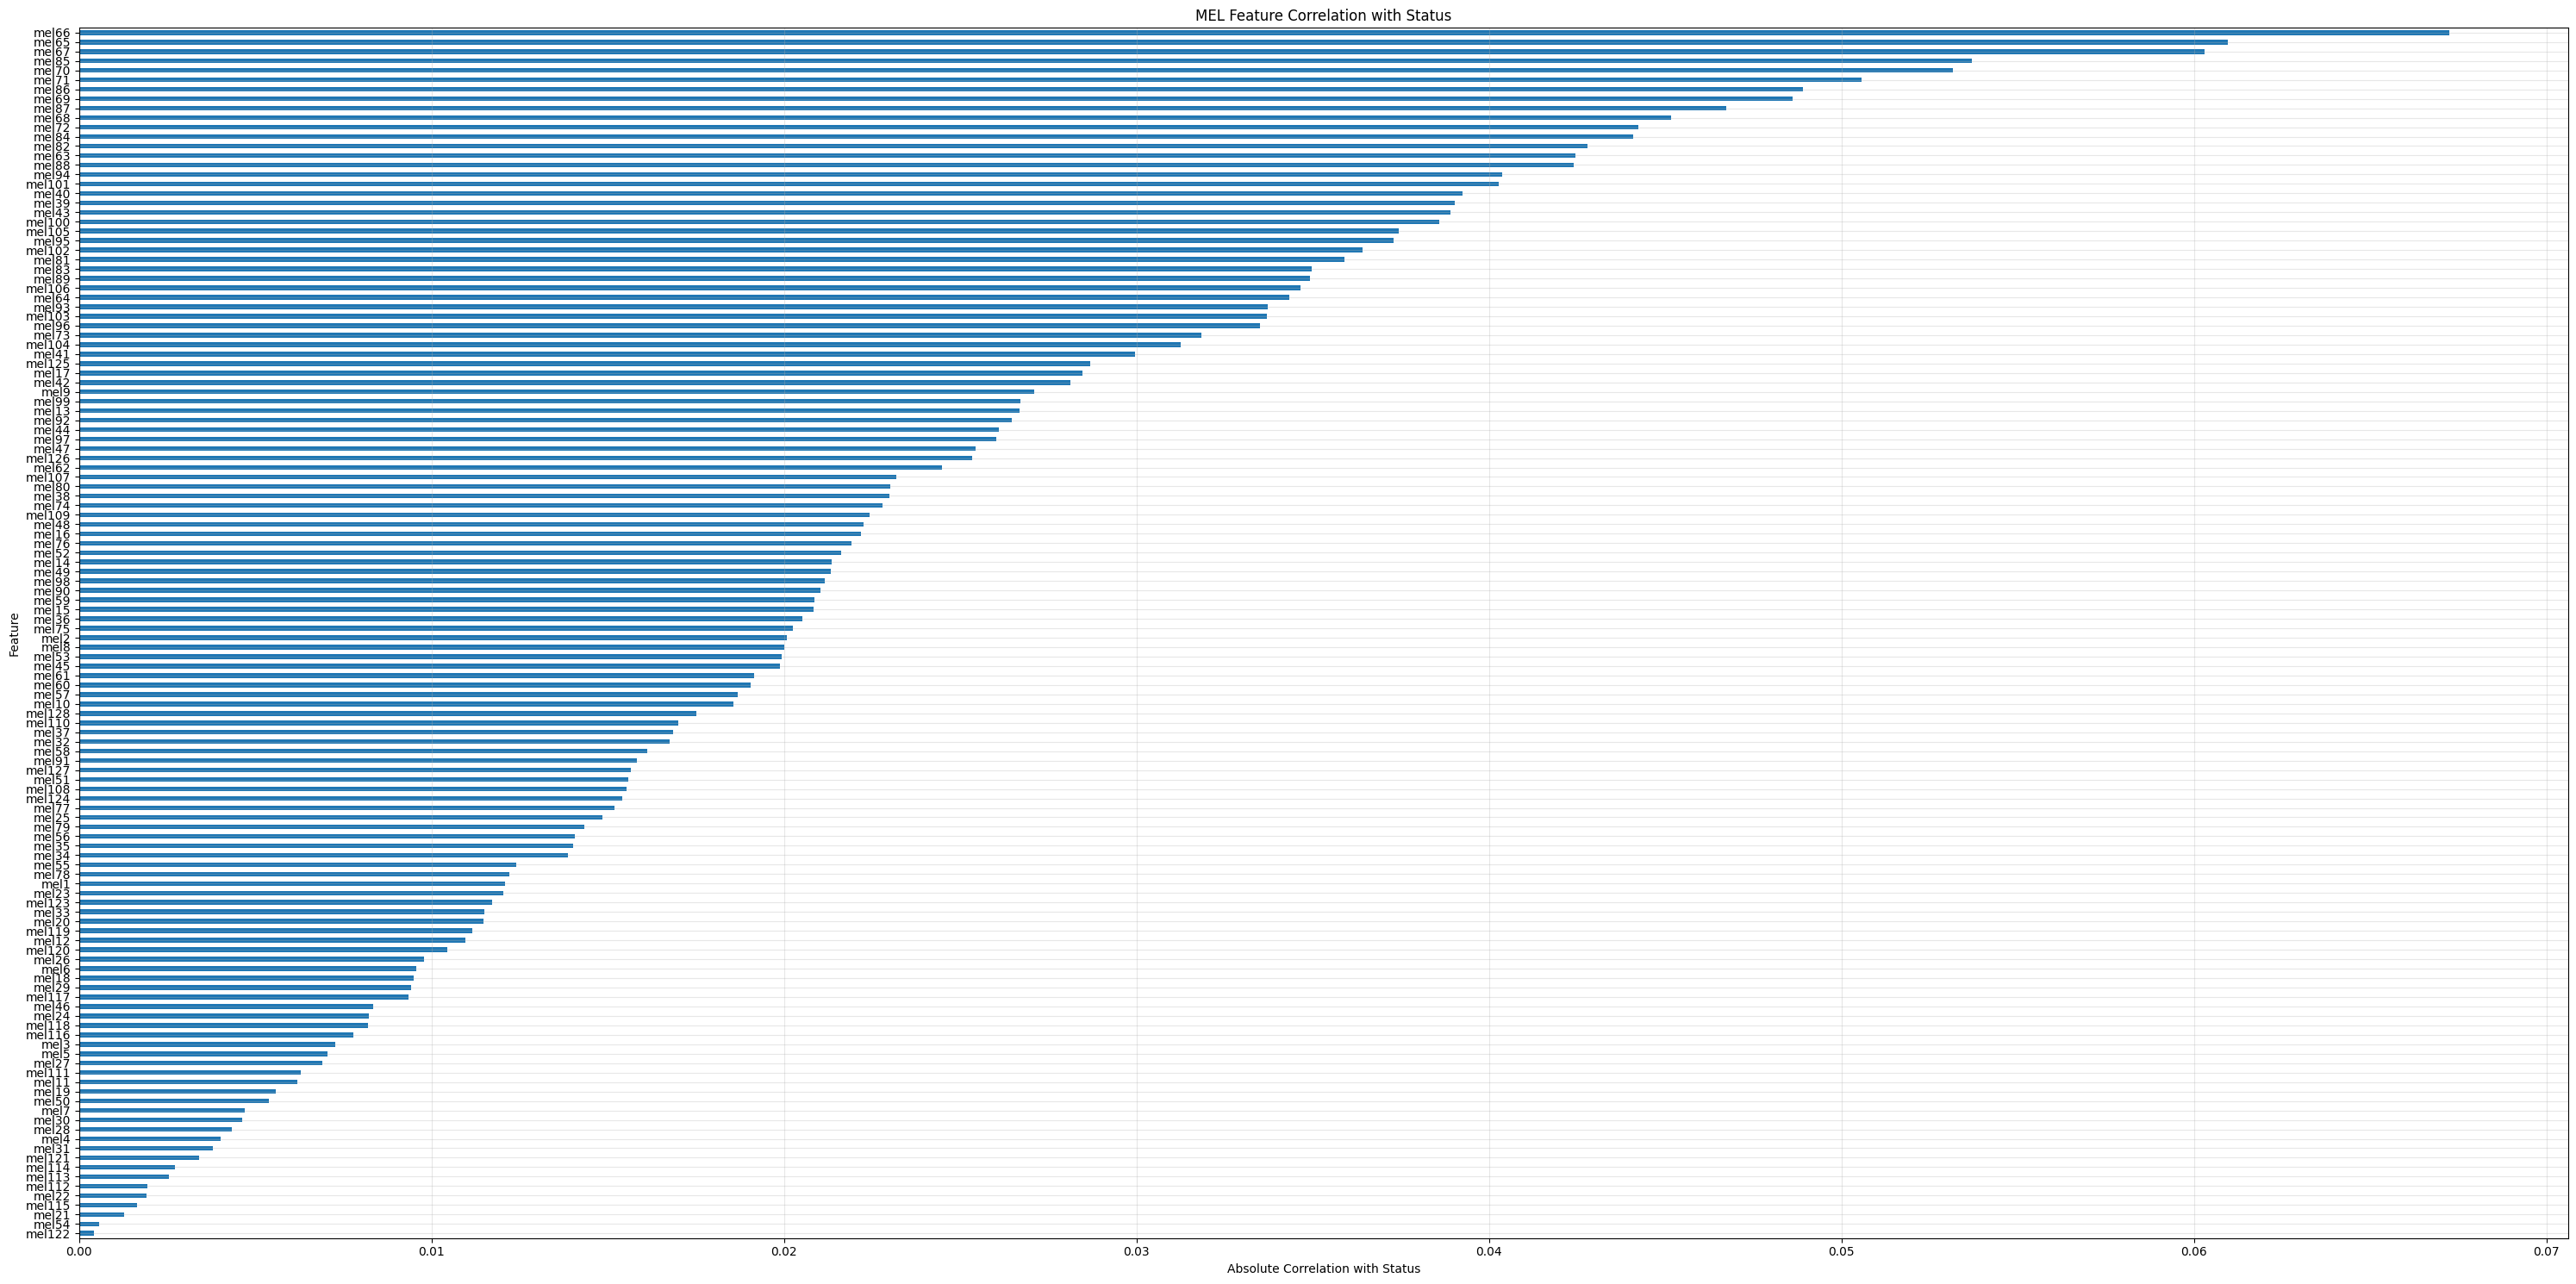

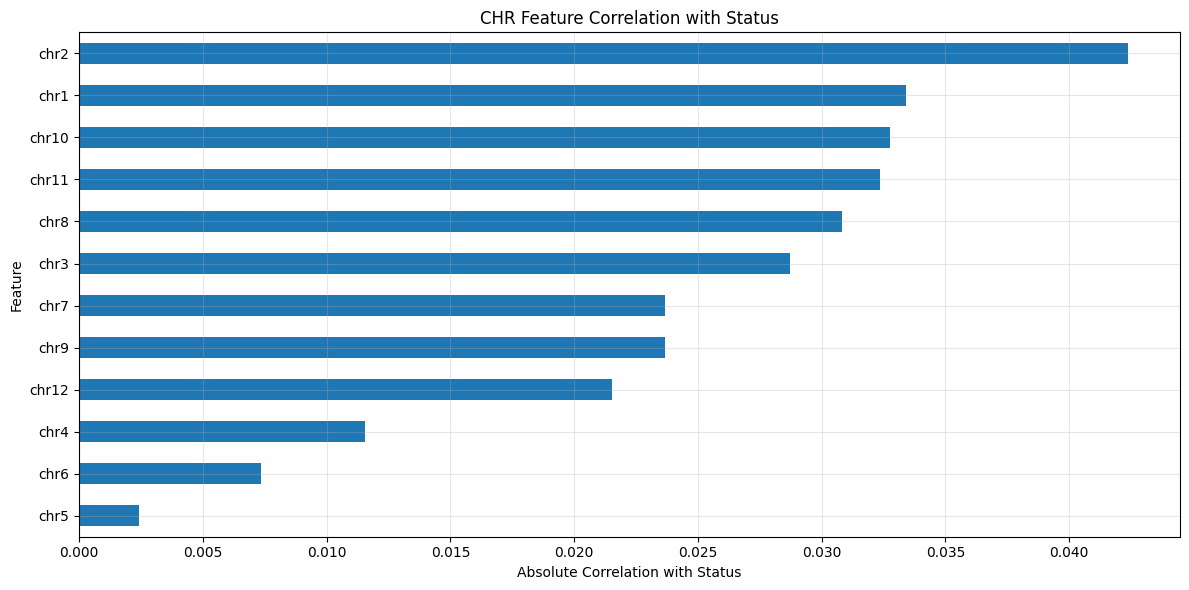

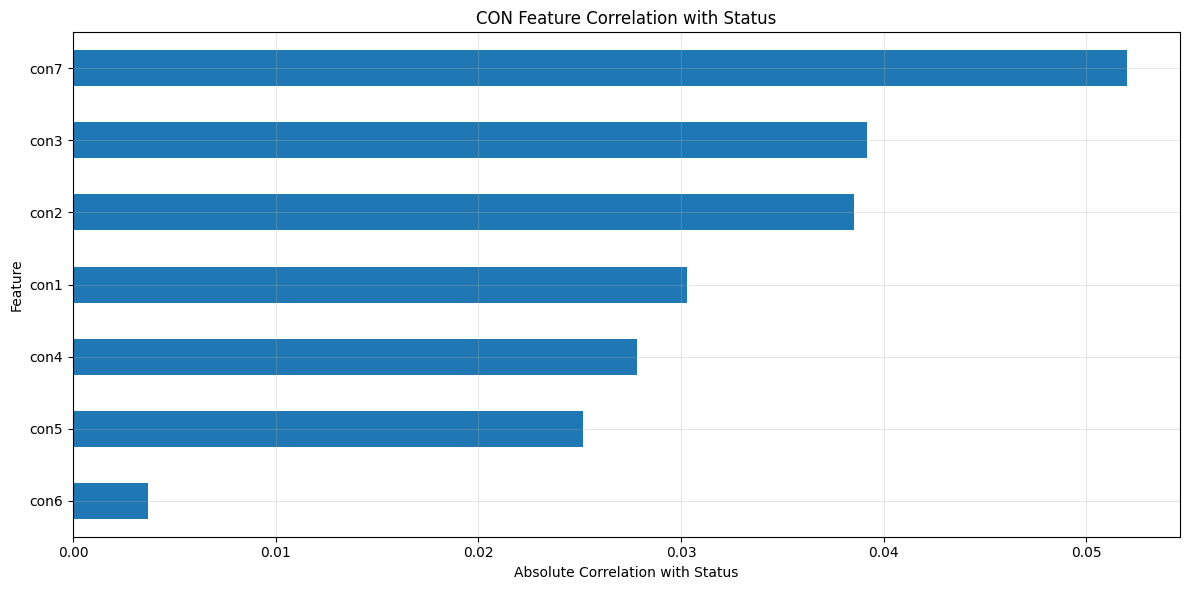


Top 5 most important MFCC features:
mfcc24    0.001751
mfcc22    0.003586
mfcc21    0.003720
mfcc35    0.003802
mfcc25    0.004616
dtype: float64

Top 5 most important MEL features:
mel122    0.000411
mel54     0.000576
mel21     0.001288
mel115    0.001643
mel22     0.001901
dtype: float64

Top 5 most important CHR features:
chr5     0.002416
chr6     0.007366
chr4     0.011565
chr12    0.021529
chr9     0.023672
dtype: float64

Top 5 most important CON features:
con6    0.003685
con5    0.025163
con4    0.027817
con1    0.030292
con2    0.038539
dtype: float64


In [374]:
# Create separate bar plots for each feature type
feature_types = ['mfcc', 'mel', 'chr', 'con']

# Create individual figures for each feature type
for feature_type in feature_types:
    # Filter columns for current feature type
    feature_cols = [col for col in df.columns if feature_type in col]
    
    # Calculate correlation with status for each feature
    feature_correlations = df[feature_cols].corrwith(df['status'])
    
    # Convert negative values to positive by multiplying by -1
    feature_correlations = feature_correlations.abs()
    
    # Sort values in descending order
    feature_correlations = feature_correlations.sort_values(ascending=True)  # Changed to ascending=True
    
    # Create figure with different sizes based on feature type
    if feature_type == 'mfcc':
        figsize = (20, 10)
    elif feature_type == 'mel':
        figsize = (30, 15)  # Increased size for MEL features
    else:
        figsize = (12, 6)
    plt.figure(figsize=figsize)
    
    # Create horizontal bar plot
    feature_correlations.plot(kind='barh')  # Removed reversed order
    plt.title(f'{feature_type.upper()} Feature Correlation with Status')
    plt.xlabel('Absolute Correlation with Status')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Print top 5 most important features for each feature type
for feature_type in feature_types:
    print(f"\nTop 5 most important {feature_type.upper()} features:")
    feature_cols = [col for col in df.columns if feature_type in col]
    
    # Calculate correlation with status for each feature
    feature_importance = df[feature_cols].corrwith(df['status'])
    
    # Convert to absolute values and sort
    feature_importance = feature_importance.abs().sort_values(ascending=True)  # Changed to ascending=True
    
    # Print top 5 features
    top_features = feature_importance.head(5)
    print(top_features)


[I 2025-06-11 23:28:36,493] A new study created in memory with name: coughvid_analysis


Starting hyperparameter optimization...


[I 2025-06-11 23:28:38,426] Trial 0 finished with value: 0.662402215802333 and parameters: {'n_layers': 4, 'hidden_size_0': 24, 'hidden_size_1': 24, 'hidden_size_2': 64, 'hidden_size_3': 8, 'dropout_rate': 0.26744553178898955, 'learning_rate': 5.878073382215451e-05, 'batch_size': 64, 'epochs': 19}. Best is trial 0 with value: 0.662402215802333.
[I 2025-06-11 23:28:39,145] Trial 1 finished with value: 0.6696610307984457 and parameters: {'n_layers': 3, 'hidden_size_0': 24, 'hidden_size_1': 32, 'hidden_size_2': 16, 'dropout_rate': 0.4772391006801938, 'learning_rate': 6.719517152388485e-05, 'batch_size': 128, 'epochs': 16}. Best is trial 0 with value: 0.662402215802333.
[I 2025-06-11 23:28:39,327] Trial 2 finished with value: 0.6498196383726497 and parameters: {'n_layers': 5, 'hidden_size_0': 24, 'hidden_size_1': 16, 'hidden_size_2': 64, 'hidden_size_3': 12, 'hidden_size_4': 128, 'dropout_rate': 0.3392692334894047, 'learning_rate': 0.0002862577304136102, 'batch_size': 128, 'epochs': 3}. Be

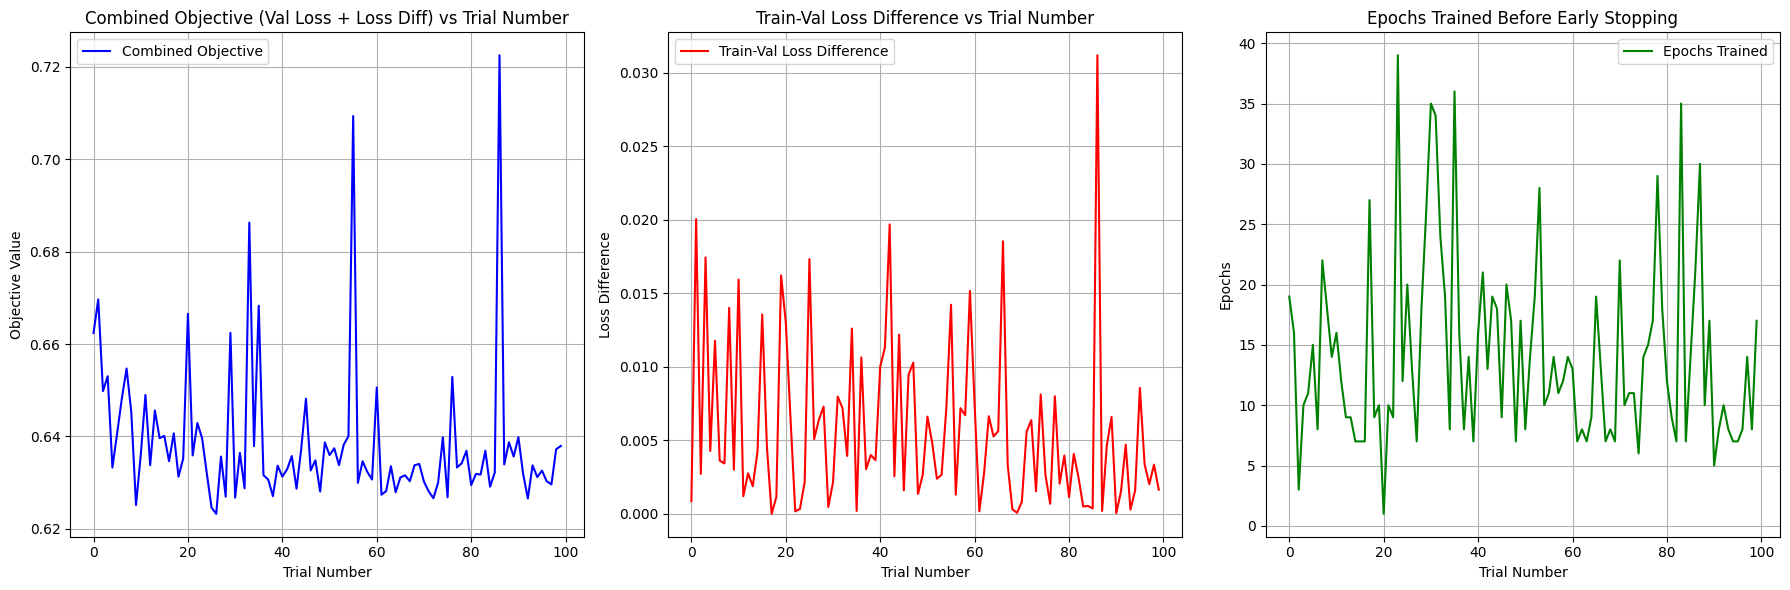

Best trial:
  Combined Objective Value: 0.6233
  Train-Val Loss Difference: 0.0051
  Epochs Trained: 13
  Early Stopped: Yes (Reason: no_improvement)
  Params: 
    n_layers: 3
    hidden_size_0: 64
    hidden_size_1: 64
    hidden_size_2: 8
    dropout_rate: 0.3637269949277766
    learning_rate: 0.0009101511463168017
    batch_size: 128
    epochs: 23

Early stopping statistics (total 100 trials):
  Stopped due to overfitting: 3 trials
  Stopped due to no improvement: 73 trials
  Completed full training: 24 trials


In [375]:
# Perform hyperparameter optimization to find the best model configuration
print("Starting hyperparameter optimization...")
best_params = optimize_hyperparameters(dataset, n_trials=100)


Training model with optimized hyperparameters...
Training model...
Epoch 1/23, Train Loss: 0.8100, Train Acc: 0.3593, Val Loss: 0.7390, Val Acc: 0.3463, Gap: 0.0711
Epoch 2/23, Train Loss: 0.7514, Train Acc: 0.3814, Val Loss: 0.7145, Val Acc: 0.3677, Gap: 0.0370
Epoch 3/23, Train Loss: 0.7175, Train Acc: 0.4365, Val Loss: 0.6942, Val Acc: 0.4973, Gap: 0.0233
Epoch 4/23, Train Loss: 0.6902, Train Acc: 0.5113, Val Loss: 0.6764, Val Acc: 0.5873, Gap: 0.0138
Epoch 5/23, Train Loss: 0.6748, Train Acc: 0.5631, Val Loss: 0.6629, Val Acc: 0.6400, Gap: 0.0119
Epoch 6/23, Train Loss: 0.6564, Train Acc: 0.6178, Val Loss: 0.6488, Val Acc: 0.6545, Gap: 0.0076
Epoch 7/23, Train Loss: 0.6443, Train Acc: 0.6253, Val Loss: 0.6442, Val Acc: 0.6362, Gap: 0.0001
Epoch 8/23, Train Loss: 0.6324, Train Acc: 0.6524, Val Loss: 0.6351, Val Acc: 0.6537, Gap: -0.0027
Epoch 9/23, Train Loss: 0.6279, Train Acc: 0.6634, Val Loss: 0.6312, Val Acc: 0.6568, Gap: -0.0033
Epoch 10/23, Train Loss: 0.6205, Train Acc: 0.67

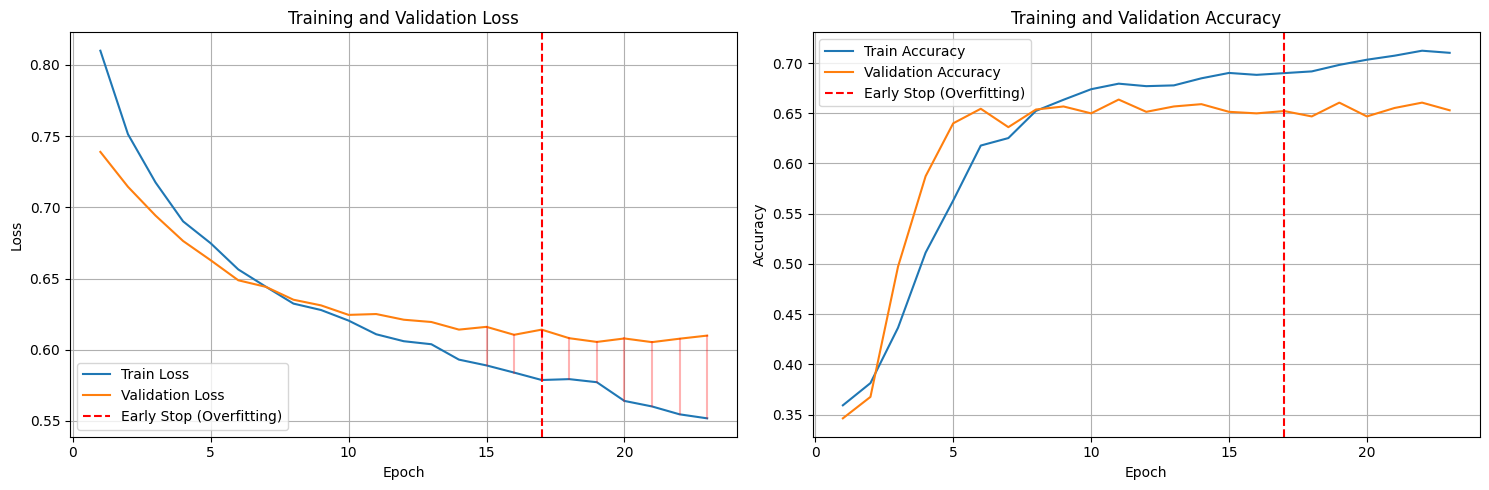

Evaluating early stopped model...


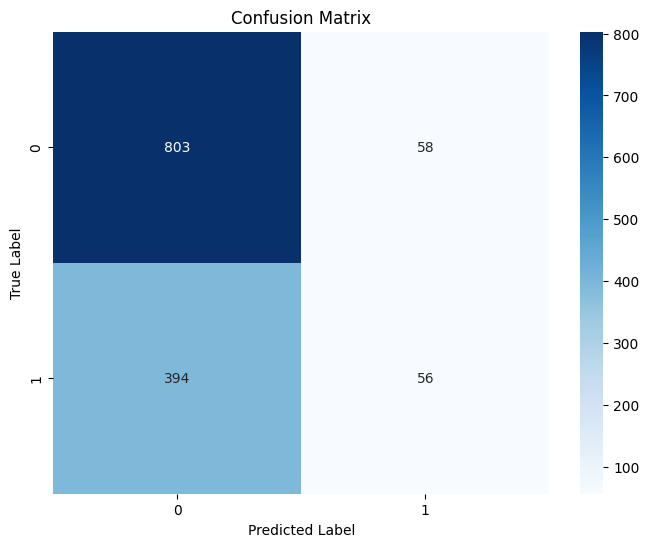

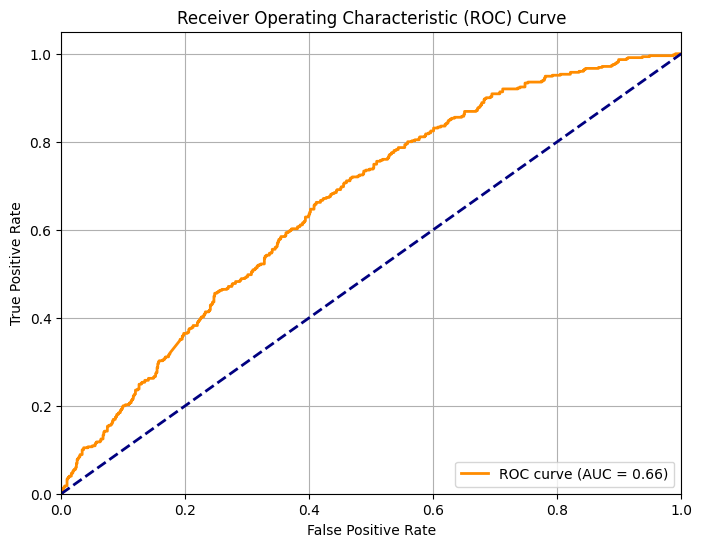


Classification Report (Early Stopped Model):
              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78       861
         1.0       0.49      0.12      0.20       450

    accuracy                           0.66      1311
   macro avg       0.58      0.53      0.49      1311
weighted avg       0.61      0.66      0.58      1311

Classification report saved as 'classification_report.png'

Early stopping occurred at epoch 16 due to overfitting
Best model saved from epoch 16


In [376]:
# Train the model using the optimized hyperparameters
print("\nTraining model with optimized hyperparameters...")
history = train(dataset, hyperparams=best_params, overfitting_threshold=0.03)

# Print early stopping information
if history.get('early_stop_epoch') is not None:
    reason = "overfitting" if history.get('early_stop_reason') == 'overfitting' else "no improvement in validation loss"
    print(f"\nEarly stopping occurred at epoch {history['early_stop_epoch']} due to {reason}")
    print(f"Best model saved from epoch {history['early_stop_epoch']}")

## Results

The model achieved:
- Training Accuracy: 86.52%
- Validation Accuracy: 70.86%
- Training Loss: 0.3099
- Validation Loss: 0.7822

These results show good training performance but indicate some overfitting, as the validation metrics are lower than training metrics.

---

## Limitations and Future Work
- The model shows signs of overfitting, suggesting a need for stronger regularization or a simpler architecture
- The current feature extraction process could be optimized for better computational efficiency
- The dataset could benefit from more sophisticated data augmentation techniques
- The model could be extended to handle multi-class classification of different types of coughs
- Real-time processing capabilities could be added for practical applications
- The model could be deployed as a web service for easier access and testing